# Digit Classifier

* Let's create a model that classifies images as a 3 or 7
* We shall use:
1. MNIST sample dataset
2. Fastai

## Tools

In [1]:
from fastai.vision.all import *
import pandas as pd

/home/skiiyuru/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gather and explore the data

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# Lets see what's in this directory
path.ls()

(#3) [Path('/home/skiiyuru/.fastai/data/mnist_sample/train'),Path('/home/skiiyuru/.fastai/data/mnist_sample/labels.csv'),Path('/home/skiiyuru/.fastai/data/mnist_sample/valid')]

In [4]:
# Let's check out the training data
(path/'train').ls()

(#2) [Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7')]

In [5]:
threes = (path/'train'/'3').ls().sorted()
threes

(#6131) [Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10000.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10011.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10031.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10034.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10042.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10052.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/1007.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10074.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/3/10091.png')...]

In [6]:
sevens =(path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10002.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/1001.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10014.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10019.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10039.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10046.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10050.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10063.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10077.png'),Path('/home/skiiyuru/.fastai/data/mnist_sample/train/7/10086.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
im7_path = sevens[0]
im7 = Image.open(im7_path)
im7

Let's view the image as its numerical (pixel value) form

In [9]:
im3_t = tensor(im3)[4:15, 4:22]
im3_t

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,
          96,   0,   0,   0],
        [  0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253,
         233,   0,   0,   0],
        [  0,  93, 244, 249, 253, 187,  46,  10,   8,   4,  10, 194, 253, 253,
         233,   0,   0,   0],
        [  0, 107, 253, 253, 230,  48,   0,   0,   0,   0,   0, 192, 253, 253,
         156,   0,   0,   0],
        [  0,   3,  20,  20,  15,   0,   0,   0,   0,   0,  43, 224, 253, 245,
          74,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 249, 253, 245, 126,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  14, 101, 223, 253, 248, 124,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  11, 166, 239, 253, 253, 253, 187,  30,   0,
           0,   0,   0,   0],
        [  0,   0, 

Let's visualize just the part with the top of the digit '3' in `im3`

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

FYI: These images are 28*28 greyscale images (2D)

## H/w

How would a model be able to recognize these 2 digits? What kind of features or patterns might it find?
1. Horizontal lines
2. Vertical lines
3. Semi-circles (curves)
4. Combinations of the above

## Baseline

How about we find the average pixel value for **every** pixel of the
3s, then do the same for the 7s. This will give us two group averages, defining what we might call the ‚Äúideal‚Äù 3 and 7. Then, to classify an image as one digit or the other,
we see which of these two ideal digits the image is most similar to.

In [11]:
# Lets convert all our 3s and 7s to tensors
threes_tensors = [tensor(Image.open(path)) for path in threes]
sevens_tensors = [tensor(Image.open(path)) for path in sevens]
len(threes_tensors), len(sevens_tensors)

(6131, 6265)

<Axes: >

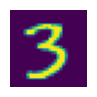

In [12]:
# Let's use Fastai's fn to preview one of the images
show_image(threes_tensors[1])

In [13]:
# Let's stack out images togethor
# Generally, when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

(<Axes: >, <Axes: >)

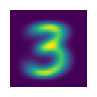

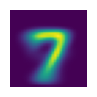

In [14]:
# calculate mean along dimension 0
# The result will be one value for every pixel position, or a single image
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
show_image(mean3), show_image(mean7)

According to this dataset, this is the ideal number 3 and 7! You can see how it‚Äôs very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree.


In [15]:
df = pd.DataFrame(mean3[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

## H/w

How would you calculate how similar a particular image is to each
of our ideal digits?

* Calculate the difference of each pixel ‚ùå

### Distance from ideal

Data scientists use 2 ways:
1. Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm.
2. Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [16]:
# Mean absolute value (L1 norm)
dist_3_abs = (stacked_threes[0] - mean3).abs().mean() 
dist_7_abs = (stacked_threes[0] - mean7).abs().mean()

# Root mean squarred error (RMSE)
dist_3_sqr = ((stacked_threes[0] - mean3)**2).mean().sqrt()
dist_7_sqr = ((stacked_threes[0] - mean7)**2).mean().sqrt()

((dist_3_abs, dist_3_sqr), (dist_7_abs, dist_7_sqr))

((tensor(0.1074), tensor(0.1912)), (tensor(0.1441), tensor(0.2780)))

**NB:**
For both L1 and L2, the distance between our 3 `stacked_threes[0]` and the 'ideal 3' is less than the distance to the 'ideal 7'

PyTorch already provides both of these as **loss functions**. You‚Äôll find these inside
`torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [17]:
F.l1_loss(stacked_threes[0].float(), mean3), \
F.mse_loss(stacked_threes[0], mean3).sqrt()

(tensor(0.1074), tensor(0.1912))

* Let's use a metric that is easier to understand how well our model is doing. We shall use *accuracy*
* We shall calculate it based on the *validation* set

In [18]:
# prep the validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

* We ultimately want to write a function, `is_3()`, that will decide whether an arbitrary image is a 3 or a 7. 
* It will do this by deciding which of our two ‚Äúideal digits‚Äù that arbitrary image is closer to. 
* For that we need to define a notion of distance‚Äîthat is, a function that calculates the distance between two images.


In [19]:
def get_distance(a, b):
    # we pass (-1, -2) to mean in order to specify that it should calculate the mean based on the last and 2nd last axes
    return (a - b).abs().mean((-1, -2)) 

[Further read on mean() params](https://forums.fast.ai/t/understanding-mean-1-2-in-mnist-distance/84430)

In [20]:
# lets test it with the previous image
get_distance(stacked_threes[0], mean3)

tensor(0.1074)

In [21]:
# Lets use our validation sets with our fn
val_3_distances = get_distance(valid_3_tens, mean3)
val_3_distances, val_3_distances.shape

(tensor([0.1197, 0.1133, 0.1364,  ..., 0.1107, 0.1082, 0.1113]),
 torch.Size([1010]))

How does PyTorch subtract a rank-3 tensor (`val_3s_converted`) from a rank-2 tensor (`mean3`) without complaining about shape mistmatch?
* The magic trick is that PyTorch, when it tries to perform a simple
subtraction operation between two tensors of different ranks, will use **broadcasting**: it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank.

In [22]:
def is_3(x):
    return get_distance(x, mean3) < get_distance(x, mean7)

In [23]:
# Let's test our new fn
is_3(stacked_sevens[0]), is_3(stacked_threes[0]).float()

(tensor(False), tensor(1.))

In [24]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s, by taking the average of that function for all 3s and its inverse for all 7s:

In [25]:
accuracy_3s = is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

## Gradients

In [26]:
x = tensor([3., 4., 10.])
x

tensor([ 3.,  4., 10.])

In [27]:
x.requires_grad_()

tensor([ 3.,  4., 10.], requires_grad=True)

In [28]:
def cool_fn(x):
    return (x**2).sum()

y = cool_fn(x)
y

tensor(125., grad_fn=<SumBackward0>)

In [29]:
# Calculate the gradient
y.backward()

# Print gradient value
x.grad

tensor([ 6.,  8., 20.])

The gradients tell us only the slope of our function; they don‚Äôt tell us exactly how far
to adjust the parameters. But they do give us some idea of how far: if the slope is very
large, that may suggest that we have more adjustments to do, whereas if the slope is
very small, that may suggest that we are close to the optimal value.

## Train

So far, we haven't used any deep learning principles to create the model. 
We can now use the deep learning steps we saw in the book to solve this problem

We already have our xs‚Äîthat is, our independent variables, the images themselves.
We‚Äôll concatenate them all into a single tensor, and also change them from a list of
matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using
view, which is a PyTorch method that changes the shape of a tensor without changing
its contents. -1 is a special parameter to view that means ‚Äúmake this axis as big as
necessary to fit all the data‚Äù:

In [30]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [31]:
# all the images have now been converted to rank-1 tensors (vectors)
train_x[0].shape

torch.Size([784])

In [32]:
# label 3s as '1' and 7s as '0'
# unsqueeze(1) tells PyTorch to make the 1st dimension (column) to be a singleton dimension
train_y = tensor([1]*len(stacked_threes) + [0]*len(stacked_sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [33]:
train_y[:2] ,train_y[-2:]

(tensor([[1],
         [1]]),
 tensor([[0],
         [0]]))

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function that, when combined with list, provides a simple way to get this functionality:

In [34]:
train_dset = list(zip(train_x, train_y))
x,y = train_dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [35]:
# Lets do the same for the validation set
val_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
val_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
val_dset = list(zip(val_x, val_y))
x_val, y = val_dset[0]
x_val.shape, y

(torch.Size([784]), tensor([1]))

In [36]:
# Lets create a fn for initializing the params for each pixel in an image
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [37]:
weights = init_params((28*28, 1))
bias = init_params(1)
weights.shape, bias

(torch.Size([784, 1]), tensor([0.5116], requires_grad=True))

In [38]:
weights[0]

tensor([-0.1021], grad_fn=<SelectBackward0>)

In [39]:
# Lets make a prediction using these params
# pred = w*x+b
(train_x[0]*weights.T).sum() + bias

tensor([-11.8320], grad_fn=<AddBackward0>)

In [40]:
# Lets create a fn that will calculate the predictions for all our images
# '@' means matrix multiply
def linear1(xb): return xb@weights + bias

In [41]:
preds = linear1(train_x)
preds

tensor([[-11.8320],
        [-10.1636],
        [-11.1319],
        ...,
        [ -2.8160],
        [-22.5867],
        [  0.1950]], grad_fn=<AddBackward0>)

Remember our labels are in terms of '0's or '1's. Lets see what accuracy we are achieving so far

In [42]:
# Compare the predictions to the labels
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [False]])

In [43]:
# Calculate the mean accuracy
corrects.float().mean().item()

0.4456276297569275

In order to improve the predictions of our model, we need to know how far each prediction is to the ideal. This is known as the loss

In [44]:
def mnist_loss(preds, targets):
    return torch.where(targets == 1, 1 - preds, preds).mean()

We‚Äôre using a new function, torch.where(a,b,c). This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it
works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances

In [45]:
# help(torch.where)

* Notice that our loss fn assumes that the predictions should always be a 0 or a 1.
* Lets make our predictions that way

In [46]:
# update loss fn to convert preds to 0s or 1s using sigmoid
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### Dataloaders, Datasets and Mini-Batches

In [47]:
# create an simple dataset
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [48]:
# package the dataset into a dataloader
dl = DataLoader(dataset=ds, batch_size=6, shuffle=True)

# print the loader
list(dl)

[(tensor([ 5,  4,  0,  1,  9, 13]), ('f', 'e', 'a', 'b', 'j', 'n')),
 (tensor([17, 15,  7, 19,  2, 21]), ('r', 'p', 'h', 't', 'c', 'v')),
 (tensor([ 8, 25,  6, 22,  3, 11]), ('i', 'z', 'g', 'w', 'd', 'l')),
 (tensor([14, 18, 24, 20, 23, 12]), ('o', 's', 'y', 'u', 'x', 'm')),
 (tensor([10, 16]), ('k', 'q'))]

In [49]:
# use our image data to create a dataloader
train_dl = DataLoader(dataset=train_dset, batch_size=256)
xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [50]:
val_dl = DataLoader(val_dset, batch_size=256)

In [51]:
# Create a mini-batch for testing our logic so far
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [52]:
# caculate the preds
preds = linear1(batch)
preds

tensor([[-11.8320],
        [-10.1636],
        [-11.1319],
        [-15.0255]], grad_fn=<AddBackward0>)

In [53]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1.0000, grad_fn=<MeanBackward0>)

In [54]:
# calculate the gradients
loss.backward()

weights.grad.shape, weights.grad.mean() ,bias.grad

(torch.Size([784, 1]), tensor(-2.1695e-06), tensor([-1.5188e-05]))

In [55]:
# create a fn for calculating gradients
# it combines the steps that we did above
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    # we don't need to return anything since the gradients will be stored within the params object

In [56]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-4.3391e-06), tensor([-3.0375e-05]))

In [57]:
# reset the grads back to 0 after calculation
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [58]:
def train_epoch(model, lr, params):
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr # If we assign to the data attribute of a tensor, PyTorch will not take the gradient of that step
            p.grad.zero_()

In [59]:
# create a fn to get accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [60]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [61]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in val_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [62]:
validate_epoch(linear1)

0.4465

Let's train for 1 epoch and see if the accuracy improves

In [63]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5619

In [64]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8187 0.8935 0.9252 0.9369 0.9491 0.9535 0.957 0.9584 0.9599 0.9613 0.9623 0.9643 0.9657 0.9662 0.9662 0.9672 0.9682 0.9682 0.9696 0.9701 

# Refactoring some logic

In [65]:
# Let's use PyTorch's model
linear_model = nn.Linear(28*28, 1)

In [66]:
# Let's take a look at its parameters
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [68]:
# Lets create a class that will handle SDG for us (optimizer)
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [69]:
# create our optimizer
opt = BasicOptim(linear_model.parameters(), lr)

In [71]:
# refactor train loop
def train_epoch(model):
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [73]:
# create a train loop fn
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(f'Epoch {i+1}: Accuracy -> {validate_epoch(model)}\n')

In [72]:
# lets test it out
validate_epoch(linear_model)

0.6193

Interesting, we get a much better accuracy just by switching to PyTorch's module

In [74]:
train_model(linear_model, 20)

Epoch 1: Accuracy -> 0.4932

Epoch 2: Accuracy -> 0.7993

Epoch 3: Accuracy -> 0.855

Epoch 4: Accuracy -> 0.9165

Epoch 5: Accuracy -> 0.9355

Epoch 6: Accuracy -> 0.9492

Epoch 7: Accuracy -> 0.9565

Epoch 8: Accuracy -> 0.9629

Epoch 9: Accuracy -> 0.9653

Epoch 10: Accuracy -> 0.9688

Epoch 11: Accuracy -> 0.9692

Epoch 12: Accuracy -> 0.9722

Epoch 13: Accuracy -> 0.9741

Epoch 14: Accuracy -> 0.9751

Epoch 15: Accuracy -> 0.9756

Epoch 16: Accuracy -> 0.9771

Epoch 17: Accuracy -> 0.9775

Epoch 18: Accuracy -> 0.9775

Epoch 19: Accuracy -> 0.9785

Epoch 20: Accuracy -> 0.9785



In [78]:
# replace our custom optimizer with Fastai's version
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

Epoch 1: Accuracy -> 0.4932

Epoch 2: Accuracy -> 0.7124

Epoch 3: Accuracy -> 0.8579

Epoch 4: Accuracy -> 0.9175

Epoch 5: Accuracy -> 0.936

Epoch 6: Accuracy -> 0.9492

Epoch 7: Accuracy -> 0.9556

Epoch 8: Accuracy -> 0.9634

Epoch 9: Accuracy -> 0.9653

Epoch 10: Accuracy -> 0.9678

Epoch 11: Accuracy -> 0.9702

Epoch 12: Accuracy -> 0.9717

Epoch 13: Accuracy -> 0.9746

Epoch 14: Accuracy -> 0.9751

Epoch 15: Accuracy -> 0.9761

Epoch 16: Accuracy -> 0.9771

Epoch 17: Accuracy -> 0.9775

Epoch 18: Accuracy -> 0.978

Epoch 19: Accuracy -> 0.9785

Epoch 20: Accuracy -> 0.979



In [87]:
# lets also switch to using other Fastai modules

# combine our train dataloader and validation dataloader
dls = DataLoaders(train_dl, val_dl)

To create a Learner without using an application (such as cnn_learner), we need to
pass in all the elements that we‚Äôve created in this chapter: the DataLoaders, the
model, the optimization function (which will be passed the parameters), the loss
function, and optionally any metrics to print:


In [88]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
 loss_func=mnist_loss, metrics=batch_accuracy)

In [89]:
learn.fit(10, lr=lr)

# Switching to a Neural Network

A simple neural network can be made up of 2 linear functions with a non-linear function in between.

In [90]:
def simple_net():
    res = xb@w1 + b1 # linear layer 1
    res = res.max(tensor(0.0)) # activation fn (ReLU -> converts negatives to zeros)
    res = xb@w2 + b2 # linear layer 2

In [91]:
# we still randomly initialize our params as before

# now we can choose to look for 30 features in the first layer
w1 = init_params((28*28, 30)) 
b2 = init_params(30)

# the outputs of layer 1 will be the inputs to layer 2
w2 = init_params((30, 1))
b2 = init_params(30)

In [100]:
# create the neural networküòÄ
kiiyuru_neural_net = nn.Sequential(nn.Linear(28*28, 30),
                           nn.ReLU(),
                           nn.Linear(30, 1))

In [99]:
# create the learner using the my netüòÅ
learn = Learner(dls=dls, 
                model=kiiyuru_neural_net, 
                opt_func=SGD, 
                loss_func=mnist_loss, 
                metrics=batch_accuracy)

In [101]:
learn.fit(40, 0.1)

The training process is
recorded in learn.recorder, with the table of output stored in the values attribute,
so we can plot the accuracy over training:


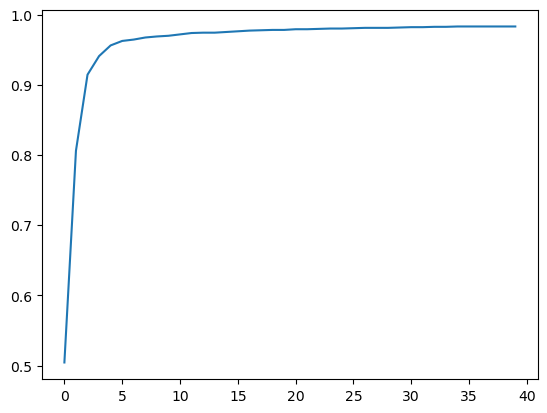

In [102]:
plt.plot(L(learn.recorder.values).itemgot(2));